In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.tree import export_text
import mglearn
from dashboard_one import *
from dash_model_two import *
from feature_selection import *
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [453]:
## models(df,drop_lst,target)

def usampling_split_scale_data(df,drop_lst,target):
    '''
    undersampling data, split data (4:1),data scaling, pca components which could explains 90% data
    ----------------------------------
    df: the full dataframe
    target: the target feature name
    -----------
    Outputs: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test
       '''
    # undersampling 
    X = df.copy()
    y = X[target]
    rus = RandomUnderSampler(random_state=432)
    X_undersampled, y_unsampled = rus.fit_resample(X, y)
    print('After undersampling data size is',len(X_undersampled),'; Resampled dataset shape %s' % Counter(y_unsampled))
    # split data
    train, test = train_test_split(X_undersampled,test_size=0.2)   
    X_train = train.drop(drop_lst,axis=1)
    y_train = train[target]
    X_test = test.drop(drop_lst,axis=1)
    y_test = test[target]
    # data scaling
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # pca components
    pca = PCA(n_components=X_train_scaled.shape[1]) # keep all n principal components 
    pca.fit(X_train_scaled) # fit PCA model with scaled data
    X_pca = pca.transform(X_train_scaled)  #transform data onto the first two principal components
    ex_ratio = pca.explained_variance_ratio_
    cum_sum = 0
    for i in range(len(ex_ratio)):
        cum_sum += ex_ratio[i]
        if cum_sum >= 0.9:  # if it could explain 90% of the data, then stop
            break
    n_com = i         
         # PCA with first n_com components
    pca = PCA(n_com)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
       #plot 
    plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Components')
    plt.plot(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red',
             label="Cumulative Explained Variance ratio")
    plt.legend(loc='upper left')
    print('\n{} principle components are needed to explain 90% of the data\n'.format(n_com))  
    print('Output dataframes sequence: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test')
    X_labels = ['original dataset','scaled dataset','%s pca-components'%n_com]
    return X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test,X_labels  

def models(df,drop_lst,target):
    '''
    for splitted data
    '''
    res = usampling_split_scale_data(df,drop_lst,target)
    y_train = res[6]
    y_test = res[7]
    X_labels = res[8]
    for i in range(len(X_labels)):
        print('- Using {}:'.format(X_labels[i]))
        X_train = res[2*i]
        X_test = res[2*i+1]
        # logistic regression
        C_lst = [0.001,0.01,0.1,1,10,100,1000]
        print('    - Logistic regression')
        for i in range(len(C_lst)):
            print('       - C = {}'.format(C_lst[i]))
            logreg = LogisticRegression(C=C_lst[i],solver='lbfgs',multi_class='auto',penalty='l2',max_iter=10000).fit(X_train,y_train)
            print('          - lbfgs_L2, Training set f1-score:{:.3f}, Test set f1-score: {:.3f}'
                  .format(f1_score(logreg.predict(X_train),y_train,average='weighted'),f1_score(logreg.predict(X_test),y_test,average='weighted')))
            logreg = LogisticRegression(C=C_lst[i],solver='saga',multi_class='auto',penalty='l1',max_iter=10000).fit(X_train,y_train)
            print('          - saga_L1, Training set f1-score:{:.3f}, Test set f1-score: {:.3f}'
                  .format(f1_score(logreg.predict(X_train),y_train,average='weighted'),f1_score(logreg.predict(X_test),y_test,average='weighted')))
            logreg = LogisticRegression(C=C_lst[i],solver='newton-cg',multi_class='auto',penalty='l2',max_iter=10000).fit(X_train,y_train)
            print('          - newton-cg_L2, Training set f1-score:{:.3f}, Test set f1-score: {:.3f}'
                  .format(f1_score(logreg.predict(X_train),y_train,average='weighted'),f1_score(logreg.predict(X_test),y_test,average='weighted')))

        # decision tree
        print('    - Decision tree')
        for i in range(1,15):
            dtree = DecisionTreeClassifier(random_state=0,max_depth=i,criterion='gini')
            dtree.fit(X_train,y_train)
            print('          - tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(dtree.predict(X_train),y_train,average='weighted'),f1_score(dtree.predict(X_test),y_test,average='weighted')))
        # random forest
        print('    - Random forest')
        for i in range(1,20):   
            m= 5*i
            forest = RandomForestClassifier(n_estimators=m,random_state=5862)
            forest.fit(X_train,y_train)
            print('          - {}trees. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(m,f1_score(forest.predict(X_train),y_train,average='weighted'),f1_score(forest.predict(X_test),y_test,average='weighted')))
        # MLP  
        print('    - MLP')
        hls = [[50,50],[20,20],[100,100],[50,50,50]] # hidden layer size
        for i in range(len(hls)):
            mlp = MLPClassifier(solver='lbfgs',random_state=460,hidden_layer_sizes = hls[i],max_iter=20000)
            mlp.fit(X_train,y_train)
            print('          - hidden layer size{}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'.format(hls[i],f1_score(mlp.predict(X_train),y_train,average='weighted'),f1_score(mlp.predict(X_test),y_test,average='weighted'))) 
            
            
            
            

##### cv_models(df,drop_lst,target,k)

def usampling_scale_data(df,drop_lst,target):
    '''
    undersampling data, NOT SPLIT data (later use CROSS VALIDATION),data scaling, pca components which could explains 90% data
    ----------------------------------
    df: the full dataframe
    drop_lst: drop the features which are not gonna be used in modeling, e.g. RID,...
    target: the target feature name
    -----------
    Outputs: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test
       '''
    # undersampling 
    y_output = df[target]
    rus = RandomUnderSampler(random_state=432)
    X_undersampled, y_unsampled = rus.fit_resample(df, y_output)
    print('After undersampling data size is',len(X_undersampled),'; Resampled dataset shape %s' % Counter(y_unsampled)) 
    # feature list for the X 
    # normal input output data
    X = X_undersampled.drop(drop_lst,axis=1)
    y = X_undersampled[target]
    # data scaling
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    # pca components
    pca = PCA(n_components=X_scaled.shape[1]) # keep all n principal components 
    pca.fit(X_scaled) # fit PCA model with scaled data
    X_pca = pca.transform(X_scaled)  #transform data onto the first two principal components
    ex_ratio = pca.explained_variance_ratio_
    cum_sum = 0
    for i in range(len(ex_ratio)):
        cum_sum += ex_ratio[i]
        if cum_sum >= 0.9:  # if it could explain 90% of the data, then stop
            break
    n_com = i         
         # PCA with first n_com components
    pca = PCA(n_com)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
       #plot 
    plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Components')
    plt.plot(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red',
             label="Cumulative Explained Variance ratio")
    plt.legend(loc='upper left')
    print('\n{} principle components are needed to explain 90% of the data\n'.format(n_com))  
    #print('Output dataframes sequence: X_,X_scaled,X_pca,y_')
    X_labels = ['original dataset','scaled dataset','%s pca-components'%n_com]
    return X,X_scaled,X_pca,y,X_labels 

def cv_models(df,drop_lst,target,k):
    '''
    df: full dataframe.
    drop_lst: drop the features which are not gonna be used in modeling, e.g. RID,...
    target: the target feature name
    k: folds of cross-validation
    '''
    res = usampling_scale_data(df,drop_lst,target) # Output dataframes sequence: X_,X_scaled,X_pca,y_
    
    y = res[3]
    X_labels = res[4]
    for i in range(3):
        X = res[i]
        print('- Using {}:'.format(X_labels[i]))
        # logistic regression
        C_lst = [0.001,0.01,0.1,1,10,100,1000]
        print('    - Logistic regression')
        for i in range(len(C_lst)):
            print('       - C = {}'.format(C_lst[i]))
            logreg = LogisticRegression(C=C_lst[i],solver='lbfgs',multi_class='auto',penalty='l2',max_iter=10000).fit(X,y)
            print('          - lbfgs_L2, average weighted f1-score of {}-cross validation:{:.3f}'.format(k,cross_val_score(logreg, X, y, cv = k,scoring='f1_weighted').mean()))
            logreg = LogisticRegression(C=C_lst[i],solver='saga',multi_class='auto',penalty='l1',max_iter=10000).fit(X_train,y_train)
            print('          - saga_L1, average weighted f1-score of {}-cross validation:{:.3f}'.format(k,cross_val_score(logreg, X, y, cv = k,scoring='f1_weighted').mean()))
            logreg = LogisticRegression(C=C_lst[i],solver='newton-cg',multi_class='auto',penalty='l2',max_iter=10000).fit(X_train,y_train)
            print('          - newton-cg_L2, average weighted f1-score of {}-cross validation:{:.3f}'.format(k,cross_val_score(logreg, X, y, cv = k,scoring='f1_weighted').mean()))

        # decision tree
        print('    - Decision tree')
        for i in range(1,15):
            dtree = DecisionTreeClassifier(random_state=0,max_depth=i,criterion='gini')
            dtree.fit(X,y)
            print('          - tree depth: {:.3f}. average weighted f1-score of {}-cross validation:{:.3f}'
                .format(i,k,cross_val_score(dtree, X, y, cv = k,scoring='f1_weighted').mean()))

        # random forest
        print('    - Random forest')
        for i in range(1,20):   
            m= 5*i
            forest = RandomForestClassifier(n_estimators=m,random_state=5862)
            forest.fit(X,y)
            print('          - {}trees. average weighted f1-score of {}-cross validation:{:.3f}'
                .format(m,k,cross_val_score(forest, X, y, cv = k,scoring='f1_weighted').mean()))
        # MLP 
        print('    - MLP')
        hls = [[50,50],[20,20],[100,100],[50,50,50]] # hidden layer size
        for i in range(len(hls)):
            mlp = MLPClassifier(solver='lbfgs',random_state=460,hidden_layer_sizes = hls[i],max_iter=20000).fit(X,y)
            mlp.fit(X,y)
            print('          - hidden layer size{}. average weighted f1-score of {}-cross validation:{:.3f}'.format(hls[i],k,cross_val_score(mlp, X, y, cv = k,scoring='f1_weighted').mean()))          

### sleep, brain_volume_ratio_to_baseline_____VS_____diagnosischanges from every visit


#### sleep_brain_dxch.csv
#### drop column 'NPIKSEV', otherwise we get no samples

In [429]:
com_col = ['Phase', 'RID', 'VISCODE','PTID']

In [464]:
sleep_brain_dxch[sleep_brain_dxch['RID']==61][com_col + ['DXCHANGE']]

,Phase,RID,VISCODE,PTID,DXCHANGE
370,ADNI1,61,m06,023_S_0061,CN-CN
371,ADNI1,61,m12,023_S_0061,CN-CN
372,ADNI1,61,m18,023_S_0061,CN-CN
373,ADNI1,61,m24,023_S_0061,CN-CN
374,ADNI1,61,m30,023_S_0061,CN-CN
375,ADNI1,61,m36,023_S_0061,CN-CN
376,ADNI1,61,m42,023_S_0061,CN-CN
377,ADNI1,61,m48,023_S_0061,CN-CN
378,ADNI1,61,m54,023_S_0061,CN-CN
379,ADNI1,61,m60,023_S_0061,CN-CN


In [460]:
sleep_brain_dxch = pd.read_csv('sleep_brain_dxch.csv').iloc[:,1:].drop(['NPIKSEV'],axis=1)
sleep_brain_dxch = sleep_brain_dxch[sleep_brain_dxch['DXCHANGE'].notna()].reset_index().drop(['index'],axis=1)   # keep the rows where DXCHANGE is not nan
sleep_brain_dxch

,RID,Phase,VISCODE,PTID,NPIK1,NPIK2,NPIK3,NPIK4,NPIK5,NPIK6,...,ratio_PTAU_bl,Ventricles_reduction_per_year,Hippocampus_reduction_per_year,wholebrain_reduction_per_year,Entorhinal_reduction_per_year,Fusiform_reduction_per_year,ICV_reduction_per_year,ABETA_reduction_per_year,TAU_reduction_per_year,PTAU_reduction_per_year
0,2,ADNI1,m06,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ADNI1,m36,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ADNI1,m60,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,ADNI1,m66,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,ADNI1,m72,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,7083,ADNI3,sc,126_S_7083,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19433,7085,ADNI3,sc,941_S_7085,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19434,7088,ADNI3,sc,033_S_7088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19435,7092,ADNI3,sc,021_S_7092,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### sleep______VS______DXCHANGE

In [431]:
col_lst = [ 'DXCHANGE','NPIK1', 'NPIK2', 'NPIK3', 'NPIK4', 'NPIK5', 'NPIK6', 'NPIK7', 'NPIK8',
       'NPIK9A', 'NPIK9B', 'NPIK9C', 'NPIKTOT',  'insomnia','OSA']
sleep_dxch = sleep_brain_dxch[com_col + col_lst].set_index(['Phase', 'RID', 'VISCODE','PTID']).dropna(how='any',axis=0).reset_index()
sleep_dxch

,Phase,RID,VISCODE,PTID,DXCHANGE,NPIK1,NPIK2,NPIK3,NPIK4,NPIK5,NPIK6,NPIK7,NPIK8,NPIK9A,NPIK9B,NPIK9C,NPIKTOT,insomnia,OSA
0,ADNI2,8,v06,011_S_0008,CN-CN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,6.0,1.0,0.0
1,ADNI2,8,v41,011_S_0008,CN-MCI,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,1.0,8.0,1.0,0.0
2,ADNI2,31,v06,023_S_0031,CN-CN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0
3,ADNI2,31,v11,023_S_0031,CN-CN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0
4,ADNI2,31,v21,023_S_0031,CN-CN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,ADNI3,6890,y1,021_S_6890,MCI-MCI,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0
903,ADNI3,6891,y1,123_S_6891,AD-AD,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,2.0,3.0,8.0,1.0,0.0
904,ADNI3,6897,y1,036_S_6897,MCI-MCI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
905,ADNI3,6947,y1,035_S_6947,MCI-MCI,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [432]:
np.sum(sleep_dxch.isna())   # check nan

Phase       0
RID         0
VISCODE     0
PTID        0
DXCHANGE    0
NPIK1       0
NPIK2       0
NPIK3       0
NPIK4       0
NPIK5       0
NPIK6       0
NPIK7       0
NPIK8       0
NPIK9A      0
NPIK9B      0
NPIK9C      0
NPIKTOT     0
insomnia    0
OSA         0
dtype: int64

In [433]:
sleep_dxch.groupby('DXCHANGE').count()

,Phase,RID,VISCODE,PTID,NPIK1,NPIK2,NPIK3,NPIK4,NPIK5,NPIK6,NPIK7,NPIK8,NPIK9A,NPIK9B,NPIK9C,NPIKTOT,insomnia,OSA
DXCHANGE,,,,,,,,,,,,,,,,,,
AD-AD,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
AD-MCI,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
CN-AD,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
CN-CN,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201,201
CN-MCI,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
MCI-AD,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
MCI-CN,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
MCI-MCI,410,410,410,410,410,410,410,410,410,410,410,410,410,410,410,410,410,410


- select only the MCI-AD, MCI-MCI

In [454]:
sleep_dxch_2g = sleep_dxch.loc[sleep_dxch['DXCHANGE'].isin(['MCI-AD','MCI-MCI'])].reset_index().drop(['index'],axis=1)
sleep_dxch_2g.shape

(487, 19)

In [435]:
sleep_dxch_3g = sleep_dxch.loc[sleep_dxch['DXCHANGE'].isin(['MCI-AD','MCI-MCI','MCI-CN'])].reset_index().drop(['index'],axis=1)
sleep_dxch_3g.shape

(528, 19)

- drop DXCHANGE labels 'AD-MCI','CN-AD','CN-CN' then undersampling

In [376]:
sleep_dxch_6g = sleep_dxch[(sleep_dxch['DXCHANGE'].isin(['CN-MCI', 'AD-AD', 'MCI-MCI', 'MCI-AD', 'MCI-CN']))].reset_index().drop(['index'],axis=1)
sleep_dxch_6g.shape

(832, 19)

### oversampling and undersampling

- functions
    - models(df,drop_lst,target) : under sampling, split, scale, pca, models
    - cv_models(df,drop_lst,target,k): under sampling, NOT SPLIT, scale, pca, models with cross-validation 

In [441]:
drop_lst = ['Phase', 'RID', 'VISCODE', 'PTID','DXCHANGE']

After undersampling data size is 154 ; Resampled dataset shape Counter({'MCI-AD': 77, 'MCI-MCI': 77})

10 principle components are needed to explain 90% of the data

Output dataframes sequence: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test
- Using original dataset:
    - Logistic regression
       - C = 0.001
          - lbfgs_L2, Training set f1-score:0.654, Test set f1-score: 0.423
          - saga_L1, Training set f1-score:0.648, Test set f1-score: 0.735
          - newton-cg_L2, Training set f1-score:0.654, Test set f1-score: 0.423
       - C = 0.01
          - lbfgs_L2, Training set f1-score:0.581, Test set f1-score: 0.492
          - saga_L1, Training set f1-score:0.648, Test set f1-score: 0.735
          - newton-cg_L2, Training set f1-score:0.581, Test set f1-score: 0.492
       - C = 0.1
          - lbfgs_L2, Training set f1-score:0.606, Test set f1-score: 0.555
          - saga_L1, Training set f1-score:0.578, Test set f1-score: 0.443
     

          - 35trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 40trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 45trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 50trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 55trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 60trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 65trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 70trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 75trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 80trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 85trees. f1-score on training data: 0.976 f1-score on test data: 0.514
          - 90trees. f1-score on training data: 0.976 f1-score on test data: 0.514
    

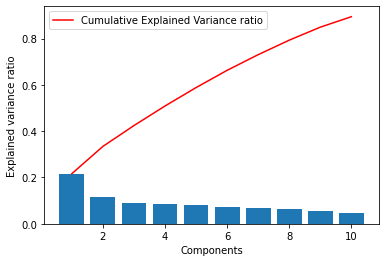

In [455]:
models(sleep_dxch_2g,drop_lst,'DXCHANGE')

After undersampling data size is 154 ; Resampled dataset shape Counter({'MCI-AD': 77, 'MCI-MCI': 77})

10 principle components are needed to explain 90% of the data

- Using original dataset:
    - Logistic regression
       - C = 0.001
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.490
          - saga_L1, average weighted f1-score of 10-cross validation:0.326
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.490
       - C = 0.01
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.534
          - saga_L1, average weighted f1-score of 10-cross validation:0.326
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.534
       - C = 0.1
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.591
          - saga_L1, average weighted f1-score of 10-cross validation:0.483
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.591
       - C = 1
          -

          - 15trees. average weighted f1-score of 10-cross validation:0.499
          - 20trees. average weighted f1-score of 10-cross validation:0.508
          - 25trees. average weighted f1-score of 10-cross validation:0.514
          - 30trees. average weighted f1-score of 10-cross validation:0.523
          - 35trees. average weighted f1-score of 10-cross validation:0.515
          - 40trees. average weighted f1-score of 10-cross validation:0.510
          - 45trees. average weighted f1-score of 10-cross validation:0.523
          - 50trees. average weighted f1-score of 10-cross validation:0.508
          - 55trees. average weighted f1-score of 10-cross validation:0.514
          - 60trees. average weighted f1-score of 10-cross validation:0.514
          - 65trees. average weighted f1-score of 10-cross validation:0.507
          - 70trees. average weighted f1-score of 10-cross validation:0.514
          - 75trees. average weighted f1-score of 10-cross validation:0.507
          - 

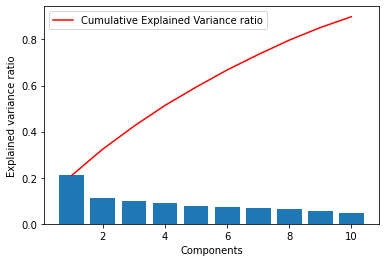

In [457]:
cv_models(sleep_dxch_2g,drop_lst,'DXCHANGE',10)

After undersampling data size is 123 ; Resampled dataset shape Counter({'MCI-AD': 41, 'MCI-CN': 41, 'MCI-MCI': 41})

9 principle components are needed to explain 90% of the data

Output dataframes sequence: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test
- Using original dataset:
    - Logistic regression
       - C = 0.001
          - lbfgs_L2, Training set f1-score:0.621, Test set f1-score: 0.447
          - saga_L1, Training set f1-score:0.504, Test set f1-score: 0.485
          - newton-cg_L2, Training set f1-score:0.621, Test set f1-score: 0.447
       - C = 0.01
          - lbfgs_L2, Training set f1-score:0.588, Test set f1-score: 0.396
          - saga_L1, Training set f1-score:0.504, Test set f1-score: 0.485
          - newton-cg_L2, Training set f1-score:0.588, Test set f1-score: 0.396
       - C = 0.1
          - lbfgs_L2, Training set f1-score:0.595, Test set f1-score: 0.440
          - saga_L1, Training set f1-score:0.534, Test set f1-score

          - 30trees. f1-score on training data: 0.938 f1-score on test data: 0.366
          - 35trees. f1-score on training data: 0.938 f1-score on test data: 0.337
          - 40trees. f1-score on training data: 0.938 f1-score on test data: 0.367
          - 45trees. f1-score on training data: 0.938 f1-score on test data: 0.367
          - 50trees. f1-score on training data: 0.938 f1-score on test data: 0.372
          - 55trees. f1-score on training data: 0.938 f1-score on test data: 0.335
          - 60trees. f1-score on training data: 0.938 f1-score on test data: 0.335
          - 65trees. f1-score on training data: 0.938 f1-score on test data: 0.372
          - 70trees. f1-score on training data: 0.938 f1-score on test data: 0.372
          - 75trees. f1-score on training data: 0.938 f1-score on test data: 0.372
          - 80trees. f1-score on training data: 0.938 f1-score on test data: 0.344
          - 85trees. f1-score on training data: 0.938 f1-score on test data: 0.344
    

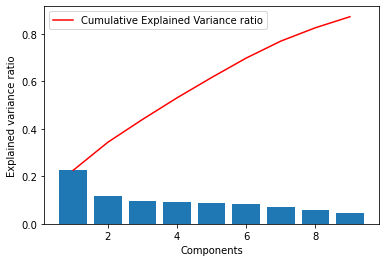

In [444]:
models(sleep_dxch_3g,drop_lst,'DXCHANGE')

normal data: random forest: 85trees. f1-score on training data: 0.969 f1-score on test data: 0.780
normal data: random forest: 85trees. f1-score on training data: 0.969 f1-score on test data: 0.780

pca:decision tree: tree depth: 6.000. f1-score on training data: 0.891 f1-score on test data: 0.810

After undersampling data size is 123 ; Resampled dataset shape Counter({'MCI-AD': 41, 'MCI-CN': 41, 'MCI-MCI': 41})

9 principle components are needed to explain 90% of the data

- Using original dataset:
    - Logistic regression
       - C = 0.001
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.433
          - saga_L1, average weighted f1-score of 10-cross validation:0.160
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.433
       - C = 0.01
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.476
          - saga_L1, average weighted f1-score of 10-cross validation:0.167
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.476
       - C = 0.1
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.440
          - saga_L1, average weighted f1-score of 10-cross validation:0.419
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.440
       - C = 

C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


          - saga_L1, average weighted f1-score of 10-cross validation:0.440
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.442
       - C = 100
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.431


C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


          - saga_L1, average weighted f1-score of 10-cross validation:0.431
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.431
       - C = 1000
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.421


C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


          - saga_L1, average weighted f1-score of 10-cross validation:0.432
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.421
    - Decision tree
          - tree depth: 1.000. average weighted f1-score of 10-cross validation:0.398
          - tree depth: 2.000. average weighted f1-score of 10-cross validation:0.421
          - tree depth: 3.000. average weighted f1-score of 10-cross validation:0.386
          - tree depth: 4.000. average weighted f1-score of 10-cross validation:0.391
          - tree depth: 5.000. average weighted f1-score of 10-cross validation:0.349
          - tree depth: 6.000. average weighted f1-score of 10-cross validation:0.332
          - tree depth: 7.000. average weighted f1-score of 10-cross validation:0.347
          - tree depth: 8.000. average weighted f1-score of 10-cross validation:0.361
          - tree depth: 9.000. average weighted f1-score of 10-cross validation:0.359
          - tree depth: 10.000. average weighted 

C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


          - saga_L1, average weighted f1-score of 10-cross validation:0.437
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.437
       - C = 1000
          - lbfgs_L2, average weighted f1-score of 10-cross validation:0.437


C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\weipi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

          - saga_L1, average weighted f1-score of 10-cross validation:0.444
          - newton-cg_L2, average weighted f1-score of 10-cross validation:0.437
    - Decision tree
          - tree depth: 1.000. average weighted f1-score of 10-cross validation:0.345
          - tree depth: 2.000. average weighted f1-score of 10-cross validation:0.415
          - tree depth: 3.000. average weighted f1-score of 10-cross validation:0.388
          - tree depth: 4.000. average weighted f1-score of 10-cross validation:0.375
          - tree depth: 5.000. average weighted f1-score of 10-cross validation:0.290
          - tree depth: 6.000. average weighted f1-score of 10-cross validation:0.348
          - tree depth: 7.000. average weighted f1-score of 10-cross validation:0.348
          - tree depth: 8.000. average weighted f1-score of 10-cross validation:0.342
          - tree depth: 9.000. average weighted f1-score of 10-cross validation:0.317
          - tree depth: 10.000. average weighted 

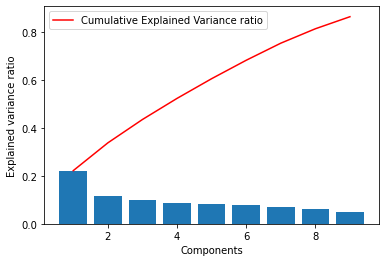

In [458]:
cv_models(sleep_dxch_3g,drop_lst,'DXCHANGE',10)

After undersampling data size is 190 ; Resampled dataset shape Counter({'AD-AD': 38, 'CN-MCI': 38, 'MCI-AD': 38, 'MCI-CN': 38, 'MCI-MCI': 38})

10 principle components are needed to explain 90% of the data

Output dataframes sequence: X_train,X_test,X_train_scaled,X_test_scaled,X_train_pca,X_test_pca,y_train,y_test
- Using original dataset:
    - Logistic regression
       - C = 0.001
          - lbfgs_L2, Training set f1-score:0.442, Test set f1-score: 0.242
          - saga_L1, Training set f1-score:0.357, Test set f1-score: 0.233
          - newton-cg_L2, Training set f1-score:0.442, Test set f1-score: 0.242
       - C = 0.01
          - lbfgs_L2, Training set f1-score:0.441, Test set f1-score: 0.249
          - saga_L1, Training set f1-score:0.357, Test set f1-score: 0.233
          - newton-cg_L2, Training set f1-score:0.441, Test set f1-score: 0.249
       - C = 0.1
          - lbfgs_L2, Training set f1-score:0.429, Test set f1-score: 0.230
          - saga_L1, Training set f1-sc

          - 30trees. f1-score on training data: 0.914 f1-score on test data: 0.294
          - 35trees. f1-score on training data: 0.914 f1-score on test data: 0.239
          - 40trees. f1-score on training data: 0.914 f1-score on test data: 0.271
          - 45trees. f1-score on training data: 0.914 f1-score on test data: 0.237
          - 50trees. f1-score on training data: 0.914 f1-score on test data: 0.237
          - 55trees. f1-score on training data: 0.914 f1-score on test data: 0.271
          - 60trees. f1-score on training data: 0.914 f1-score on test data: 0.265
          - 65trees. f1-score on training data: 0.914 f1-score on test data: 0.270
          - 70trees. f1-score on training data: 0.914 f1-score on test data: 0.271
          - 75trees. f1-score on training data: 0.914 f1-score on test data: 0.271
          - 80trees. f1-score on training data: 0.915 f1-score on test data: 0.270
          - 85trees. f1-score on training data: 0.914 f1-score on test data: 0.270
    

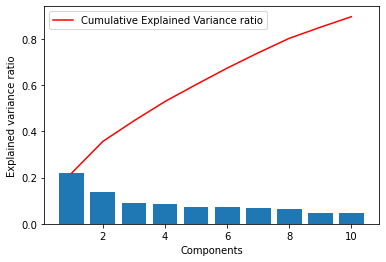

In [452]:
models(sleep_dxch_6g,drop_lst,'DXCHANGE')

After undersampling data size is 190 ; Resampled dataset shape Counter({'AD-AD': 38, 'CN-MCI': 38, 'MCI-AD': 38, 'MCI-CN': 38, 'MCI-MCI': 38})

10 principle components are needed to explain 90% of the data



NameError: name 'X_' is not defined

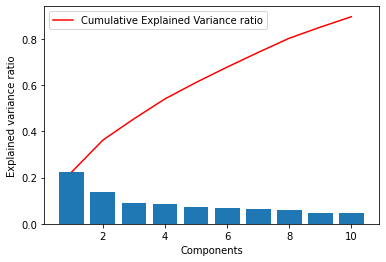

In [445]:
cv_models(sleep_dxch_6g,drop_lst,'DXCHANGE',5)

## best score: newton-cg_L2,C:1, Training set score:0.711, Test set score: 0.688

## sleep vs final_diagnosis

In [426]:
sleep_brain_finaldxch = pd.read_csv('sleep_brain_finaldxch.csv',sep=',').iloc[:,1:]
sleep_brain_finaldxch

,RID,Phase,VISCODE,PTID,NPIK1,NPIK2,NPIK3,NPIK4,NPIK5,NPIK6,...,ratio_PTAU_bl,Ventricles_reduction_per_year,Hippocampus_reduction_per_year,wholebrain_reduction_per_year,Entorhinal_reduction_per_year,Fusiform_reduction_per_year,ICV_reduction_per_year,ABETA_reduction_per_year,TAU_reduction_per_year,PTAU_reduction_per_year
0,2,ADNI1,sc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ADNI1,m06,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ADNI1,m36,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,ADNI1,m60,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,ADNI1,m66,011_S_0002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24379,679,ADNI1,m186,041_S_0679,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.073308,0.004114,0.003316,-0.006792,-0.007425,0.004080,NaN,NaN,NaN
24380,4401,ADNI2,m120,014_S_4401,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.055952,0.006005,0.007223,-0.013059,0.004802,0.002871,NaN,NaN,NaN
24381,4644,ADNI2,m108,003_S_4644,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.032266,0.004784,0.001844,-0.005400,0.011367,-0.002509,NaN,NaN,NaN
24382,5100,ADNI2,m108,041_S_5100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.077513,0.010280,0.007247,-0.014872,0.006389,0.005107,NaN,NaN,NaN


In [427]:
sleep_brain_finaldxch.columns

Index(['RID', 'Phase', 'VISCODE', 'PTID', 'NPIK1', 'NPIK2', 'NPIK3', 'NPIK4',
       'NPIK5', 'NPIK6', 'NPIK7', 'NPIK8', 'NPIK9A', 'NPIK9B', 'NPIK9C',
       'NPIKTOT', 'NPIKSEV', 'insomnia', 'OSA', 'final_dxch',
       'ratio_Ventricles_bl', 'ratio_Hippocampus_bl', 'ratio_WholeBrain_bl',
       'ratio_Entorhinal_bl', 'ratio_Fusiform_bl', 'ratio_ICV_bl',
       'ratio_ABETA_bl', 'ratio_TAU_bl', 'ratio_PTAU_bl',
       'Ventricles_reduction_per_year', 'Hippocampus_reduction_per_year',
       'wholebrain_reduction_per_year', 'Entorhinal_reduction_per_year',
       'Fusiform_reduction_per_year', 'ICV_reduction_per_year',
       'ABETA_reduction_per_year', 'TAU_reduction_per_year',
       'PTAU_reduction_per_year'],
      dtype='object')

In [ ]:
fig, axes = plt.subplots(nrows=54, ncols=3, figsize=(18,280))
axes = axes.ravel()  # array to 1D
for j in range(len(sleep_lst)):
    for i in range(len(cat_lst)):
        axes[i+j*9].scatter(sleep_brain_v[sleep_lst[j]], sleep_brain_v[cat_lst[i]])
        axes[i+j*9].set(title=f'{sleep_lst[j]} vs {cat_lst[i]}', xlabel=None)   
fig.tight_layout()
plt.show()

NPIKSEV, insomnia, OSA have data available to correlate to 

NPIKSEV vs brain volume ratio to baseline

In [ ]:
sleep_brain_v = sleep_brain_v.drop(['NPIK1', 'NPIK2', 'NPIK3', 'NPIK4',
       'NPIK5', 'NPIK6', 'NPIK7', 'NPIK8', 'NPIK9A', 'NPIK9B', 'NPIK9C',
       'NPIKTOT'],axis=1)
sleep_brain_v

In [ ]:
sleep_brain_red = sleep_brain_v.dropna(how='any',axis=0).reset_index().drop(['index'],axis=1)  # reduced
sleep_brain_red

In [ ]:
sleep_brain_red.columns

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(sleep_brain_red[['NPIKSEV', 'insomnia', 'OSA',
       'ratio_Ventricles_bl', 'ratio_Hippocampus_bl', 'ratio_WholeBrain_bl',
       'ratio_Entorhinal_bl', 'ratio_Fusiform_bl', 'ratio_ICV_bl',
       'ratio_ABETA_bl', 'ratio_TAU_bl', 'ratio_PTAU_bl']])

In [ ]:
sleep_brain_red.columns

In [ ]:
train,test = train_test_split(sleep_brain_red,random_state=586,test_size=0.25)

In [ ]:
train.index

In [ ]:
test.index

In [ ]:
X_train = train[['NPIKSEV', 'insomnia', 'OSA',
       'ratio_ABETA_bl', 'ratio_TAU_bl', 'ratio_PTAU_bl']]
X_test = test[['NPIKSEV', 'insomnia', 'OSA',
       'ratio_ABETA_bl', 'ratio_TAU_bl', 'ratio_PTAU_bl']]
y_lst = ['Ventricles_reduction_per_year', 'Hippocampus_reduction_per_year',
       'wholebrain_reduction_per_year', 'Entorhinal_reduction_per_year',
       'Fusiform_reduction_per_year', 'ICV_reduction_per_year',
       'ABETA_reduction_per_year', 'TAU_reduction_per_year',
       'PTAU_reduction_per_year','ratio_Ventricles_bl', 'ratio_Hippocampus_bl', 'ratio_WholeBrain_bl',
       'ratio_Entorhinal_bl', 'ratio_Fusiform_bl', 'ratio_ICV_bl',
       'ratio_ABETA_bl', 'ratio_TAU_bl', 'ratio_PTAU_bl']
alpha_lst = [0.01,0.1,1,10]
for i in range(len(y_lst)):
    y_train = train[y_lst[i]]
    y_test = test[y_lst[i]]
    for j in range(len(alpha_lst)):
        
        ridge = Ridge(alpha = alpha_lst[j]).fit(X_train,y_train)
        print('{}: target feature {}: alpha = {}; training set score: {:.3f}; test set score {:.3f}'.format('Ridge',y_lst[i],alpha_lst[j],lr.score(X_train,train_whole_brain),lr.score(X_test,test_whole_brain)))
        lasso = Lasso(alpha = alpha_lst[j]).fit(X_train,y_train)
        print('{}: target feature {}: alpha = {}; training set score: {:.3f}; test set score {:.3f}'.format('Lasso',y_lst[i],alpha_lst[j],lr.score(X_train,train_whole_brain),lr.score(X_test,test_whole_brain)))
        

In [ ]:
# scale data to use PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pca = PCA(n_components=3) #keep the first two principal components of the data
pca.fit(X_train_scaled) # fit PCA model to sleep-diagnosis_change data
X_pca = pca.transform(X_train_scaled)  #transform data onto the first two principal components
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red',
             label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left')
plt.show()

# The component 1 can explain about 20% of the variance, conponent 2 can explain about 11.7%,... 
# It needs almost 10 principal components to explain at least 90% of the variance. 
pca = PCA(n_components=3) 
pca.fit(X_train_scaled) # fit PCA model to sleep-diagnosis_change data
X_pca = pca.transform(X_train_scaled)  #transform data onto the first two principal components
print("Origianl shape: {}".format(str(X_train_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
# plot
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0],X_pca[:,1],train['wholebrain_reduction_per_year'])
plt.legend(train['wholebrain_reduction_per_year'].unique(),loc='best')
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel('Seconde principal component')

print('PCA components: \n{}'.format(pca.components_))    # PCA components
plt.figure(figsize=(12,12))
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3],['First component','Seconde component','Third component','Fourth component'])
plt.colorbar()
plt.xticks(range(len(X_train.columns)),X_train.columns,rotation=60,ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')


## try to use all variables to predict diagnosis

In [ ]:
main_file = pd.read_csv('main_file.csv',sep=',')
main_2 = main_file[com_col + ['DX','DXCHANGE']]
sleep_bio_brain_dx = sleep_brain_v.merge(main_2,how='left',on=com_col).dropna(axis=1, how='all')
sleep_bio_brain_dx 

In [ ]:
sleep_bio_brain_dx = sleep_bio_brain_dx.dropna(how='any',axis=0)
train,test = train_test_split(sleep_bio_brain_dx,random_state=586,test_size=0.25)
X_train = train.drop(['Phase', 'RID', 'VISCODE','PTID','DX','DXCHANGE'],axis=1)
X_test = test.drop(['Phase', 'RID', 'VISCODE','PTID','DX','DXCHANGE'],axis=1)
y_lst = ['DX','DXCHANGE']
for j in range(len(y_lst)):
    y_train = train[y_lst[j]]
    y_test = test[y_lst[j]]
    print('target feature: {}'.format(y_lst[j]))
    for i in range(1,14):
        tree = DecisionTreeClassifier(random_state=5850,max_depth=i,criterion='gini')
        tree.fit(X_train,y_train)
        print('    Decision tree with unscaled data. tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(tree.predict(X_train),y_train,average='weighted'),f1_score(tree.predict(X_test),y_test,average='weighted')))
        forest = RandomForestClassifier(n_estimators = 200, random_state = 560)
        forest.fit(X_train,y_train)
        print('    Random forest with unscaled data. n_estimators: 200. tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(forest.predict(X_train),y_train,average='weighted'),f1_score(forest.predict(X_test),y_test,average='weighted')))
    # MLP with unscaled data
    mlp = MLPClassifier(solver='lbfgs',random_state=785,hidden_layer_sizes = [100,100],max_iter=40000)
    mlp.fit(X_train,y_train)
    print('    -MLP with uscaled data. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
      .format(f1_score(mlp.predict(X_train),y_train,average='weighted'),f1_score(mlp.predict(X_test),y_test,average='weighted')))

For the target feature DXCHANGE tree depth of 3 works best. 

with f1-score on training data: 0.786 f1-score on test data: 0.606

In [ ]:
# scaled data 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for j in range(len(y_lst)):
    y_train = train[y_lst[j]]
    y_test = test[y_lst[j]]
    print('target feature: {}'.format(y_lst[j]))
    for i in range(2,14):
        tree = DecisionTreeClassifier(random_state=5850,max_depth=i,criterion='gini')
        tree.fit(X_train_scaled,y_train)
        print('    Decision tree with scaled data. tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(tree.predict(X_train_scaled),y_train,average='weighted'),f1_score(tree.predict(X_test_scaled),y_test,average='weighted')))
        forest = RandomForestClassifier(n_estimators = 200, random_state = 560)
        forest.fit(X_train_scaled,y_train)
        print('    Random forest with scaled data. n_estimators: 200. tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(forest.predict(X_train_scaled),y_train,average='weighted'),f1_score(forest.predict(X_test_scaled),y_test,average='weighted')))
    # MLP with scaled data
    mlp = MLPClassifier(solver='lbfgs',random_state=785,hidden_layer_sizes = [200,200],max_iter=40000)
    mlp.fit(X_train_scaled,y_train)
    print('    -MLP with uscaled data. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
      .format(f1_score(mlp.predict(X_train_scaled),y_train,average='weighted'),f1_score(mlp.predict(X_test_scaled),y_test,average='weighted')))

 DXCHANGE: Decision tree with scaled data. tree depth: 3.000. f1-score on training data: 0.786 f1-score on test data: 0.606
 
 DX: Decision tree with scaled data. tree depth: 2.000. f1-score on training data: 0.778 f1-score on test data: 0.487

In [ ]:
# PCA
pca = PCA(n_components=X_train_scaled.shape[1]) #keep the first two principal components of the data
pca.fit(X_train_scaled) # fit PCA model to sleep-diagnosis_change data
X_pca = pca.transform(X_train_scaled)  #transform data onto the first two principal components
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red',
             label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left')
plt.show()

# plot
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0],X_pca[:,1],train['DXCHANGE'])
plt.legend(train['DXCHANGE'].unique(),loc='best')
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel('Seconde principal component')


plt.figure(figsize=(18,18))
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5,6],['First component','Seconde component','Third component','Fourth component','Fifth component','Sixth component','seventh component'])
plt.colorbar()
plt.xticks(range(len(X_train.columns)),X_train.columns,rotation=60,ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

In [ ]:
# decision tree with PCA data 

for k in range(len(y_lst)):
    y_train = train[y_lst[k]]
    y_test = test[y_lst[k]]
    print('- target feature: {}'.format(y_lst[k]))
    max_f1_test = 0
    max_n_component = 0
    tree_depth = 0
    _f1_train = 0
    for j in range(2,X_train_scaled.shape[1]):
        pca = PCA(n_components=j) # keep the first j principal components of the data
        pca.fit(X_train_scaled) # fit PCA model to sleep-diagnosis_change data
        X_pca = pca.transform(X_train_scaled)  #transform data onto the first two principal components
        X_test_pca = pca.transform(X_test_scaled)
        #print('   - Decision tree with PCA {} components:'.format(j))
        
        for i in range(1,14):
            tree = DecisionTreeClassifier(random_state=580,max_depth=i,criterion='gini')
            tree.fit(X_pca,y_train)
            f1_score_test = f1_score(tree.predict(X_test_pca),y_test,average='weighted')
            f1_score_train = f1_score(tree.predict(X_pca),y_train,average='weighted')
            #print('        - tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'.format(i,f1_score_train,f1_score_test))
            forest = RandomForestClassifier(n_estimators = 200, random_state = 560)
        forest.fit(X_pca,y_train)
        print('    Random forest with pca data. n_estimators: 200. tree depth: {:.3f}. f1-score on training data: {:.3f} f1-score on test data: {:.3f}'
              .format(i,f1_score(forest.predict(X_pca),y_train,average='weighted'),f1_score(forest.predict(X_test_pca),y_test,average='weighted')))
        if f1_score_test >= max_f1_test:
                max_f1_test = f1_score_test
                _f1_train = f1_score_train
                max_n_component = j
                tree_depth = i
    print('The decision tree model predicting target feature {} with {:.3f} components, tree-depth of {} has the best f1-score on test set {:.3f}, on train set{:.3f}.'
          .format(y_lst[k],max_n_component,tree_depth, max_f1_test,_f1_train))
        

To predict feature DX

In [ ]:
y_train = train['DX']
y_test = test['DX']
clf = tree.DecisionTreeClassifier(random_state=580,max_depth=5,criterion='gini')
clf = clf.fit(X_pca,y_train)
fig = plt.figure(figsize=(20,15))
tree.plot_tree(clf,fontsize=15)

To predict feature DXCHANGE

In [ ]:
train,test = train_test_split(sleep_bio_brain_dx,random_state=586,test_size=0.25)
X_train = train.drop(['Phase', 'RID', 'VISCODE','PTID','DX','DXCHANGE'],axis=1)
X_test = test.drop(['Phase', 'RID', 'VISCODE','PTID','DX','DXCHANGE'],axis=1)
feature_list = ['NPIKSEV', 'insomnia', 'OSA', 'ratio_Ventricles_bl',
       'ratio_Hippocampus_bl', 'ratio_WholeBrain_bl', 'ratio_Entorhinal_bl',
       'ratio_Fusiform_bl', 'ratio_ICV_bl', 'ratio_ABETA_bl', 'ratio_TAU_bl',
       'ratio_PTAU_bl', 'Ventricles_reduction_per_year',
       'Hippocampus_reduction_per_year', 'wholebrain_reduction_per_year',
       'Entorhinal_reduction_per_year', 'Fusiform_reduction_per_year',
       'ICV_reduction_per_year', 'ABETA_reduction_per_year',
       'TAU_reduction_per_year', 'PTAU_reduction_per_year']
y_train = train['DXCHANGE']
y_test = test['DXCHANGE']
clf = tree.DecisionTreeClassifier(random_state=5850,max_depth=3,criterion='gini')
clf.fit(X_train,y_train)
r = export_text(clf, feature_names=feature_list)
print(r)
fig = plt.figure(figsize=(20,15))
tree.plot_tree(clf,fontsize=15,feature_names=feature_list)

print('    Decision tree with unscaled data. tree depth: 2. f1-score on training data: {0.786} f1-score on test data: {0.606}')        